# Demo: Spatial data from Slide-seq

This demo uses data from: 

_Slide-seq: A scalable technology for measuring genome-wide expression at high spatial resolution_

  - Rodriques et al (Science 2019)
  - [https://doi.org/10.1126/science.aaw1219](https://doi.org/10.1126/science.aaw1219)


For this demo, you need the data files for Puck_180819_12

Taken from: https://portals.broadinstitute.org/single_cell/study/SCP354/slide-seq-study#study-summary

Specifically these two files:

- MappedDGEForR.csv
- BeadMapping_10-17_1014/BeadLocationsForR.csv


## Covered Here

- Data preprocessing and filtering
- Computing Autocorrelation in Hotspot to identify spatial genes
- Computing local correlations between spatial genes to identify modules
- Plotting modules, correlations, and module scores

In [1]:
import numpy as np
import pandas as pd
import hotspot
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

# Load the counts and positions
counts_file = 'MappedDGEForR.csv'
pos_file = 'BeadMapping_10-17_1014/BeadLocationsForR.csv'

pos = pd.read_csv(pos_file, index_col=0)
counts = pd.read_csv(counts_file, index_col=0) # Takes a while, ~10min

# Align the indices
counts = counts.loc[:, pos.index]
barcodes = pos.index.values

# Swap position axes
# We swap x'=y and y'=-x to match the slides in the paper
pos = pd.DataFrame(
    {
        'X': pos.ycoord,
        'Y': pos.xcoord*-1,
    }, index=pos.index
)

num_umi = counts.sum(axis=0)

# Filter genes
gene_counts = (counts > 0).sum(axis=1)
valid_genes = gene_counts >= 50
counts = counts.loc[valid_genes]

## Creating the Hotspot object

To start an analysis, first creat the hotspot object
When creating the object, you need to specify:

- The gene counts matrix
- Which background model to use
- The latent space we are using to compute our cell metric
    - Here we use the physical barcode positions
- The per-cell scaling factor
    - Here we use the number of umi per barcode
    
Once the object is created, the neighborhood graph must be computed with `create_knn_graph`

The two options that are specificied are `n_neighbors` which determines the size of the neighborhood, and `weighted_graph`.

Here we set `weighted_graph=False` to just use binary, 0-1 weights and `n_neighbors=300` to create a local neighborhood size of the nearest 300 barcodes.  Larger neighborhood sizes can result in more robust detection of correlations and autocorrelations at a cost of missing more fine-grained, smaller-scale, spatial patterns

In [2]:
# Create the Hotspot object and the neighborhood graph

hs = hotspot.Hotspot(counts, model='bernoulli', latent=pos, umi_counts=num_umi)

hs.create_knn_graph(
    weighted_graph=False, n_neighbors=300,
)

## Determining genes with spatial variation

Now we compute autocorrelations for each gene, using the spatial metric, to determine which genes have the most spatial variation.

In [3]:
hs_results = hs.compute_autocorrelations(jobs=16)

hs_results.head()

100%|██████████| 6942/6942 [00:27<00:00, 250.89it/s]


G  EG         stdG           Z         C  Pval  FDR
Gene                                                                  
Ttr     1.895617e+06   0  4349.885976  435.785413  0.195658   0.0  0.0
Plp1    1.070512e+06   0  4349.885976  246.101150  0.109810   0.0  0.0
Enpp2   9.047060e+05   0  4349.885976  207.983833  0.099028   0.0  0.0
Fth1    9.041625e+05   0  4349.885976  207.858890  0.092616   0.0  0.0
Cartpt  7.867150e+05   0  4349.885976  180.858760  0.084189   0.0  0.0

## Grouping genes into spatial modules

To get a better idea of what spatial patterns exist, it is helpful to group the genes into modules.

Hotspot does this using the concept of "local correlations" - that is, <br> 
correlations that are computed between genes between cells in the same neighborhood.

Here we avoid running the calculation for all Genes x Genes pairs and instead <br> only run this on genes that have significant spatial autocorrelation to begin with.

The method `compute_local_correlations` returns a Genes x Genes matrix of <br>
Z-scores for the significance of the correlation between genes.  This object <br>
is also retained in the `hs` object and is used in the subsequent steps.

In [4]:
# Select the genes with significant spatial autocorrelation
hs_genes = hs_results.index[hs_results.FDR < 0.05]

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=20)


  0%|          | 0/845 [00:00<?, ?it/s]

Computing pair-wise local correlation on 845 features...


100%|██████████| 356590/356590 [59:29<00:00, 99.89it/s]  


Now that pair-wise local correlations are calculated, we can group genes into modules.

To do this, a convenience method is included `create_modules` which performs <br> 
agglomerative clustering with two caveats:

- If the FDR-adjusted p-value of the correlation between two branches exceeds `fdr_threshold`, <br>
then the branches are not merged.
- If two branches are two be merged and they are both have at least `min_gene_threshold` genes, <br>
then the branches are not merged.  Further genes that would join to the resulting merged module <br> (and are therefore ambiguous) either remain unassigned (if `core_only=True`) or are assigned to the module with the <br>
smaller average correlations between genes, i.e. the least-dense module (if `core_only=False`)

The output is a Series that maps gene to module number.  Unassigned genes are indicated with a module number of `-1`

This method was used to preserved substructure (nested modules) while still giving the analyst <br>
some control. However, since there are a lot of ways to do hierarchical clustering, you can also <br>
manually cluster using the gene-distances in `hs.local_correlation_z`



In [5]:
modules = hs.create_modules(
    min_gene_threshold=20, core_only=False, fdr_threshold=0.05
)

modules.value_counts()

 4    230
 3    170
-1    143
 2    102
 1    101
 5     63
 6     36
Name: Module, dtype: int64

## Plotting module correlations

A convenience method is supplied to plot the results of `hs.create_modules`

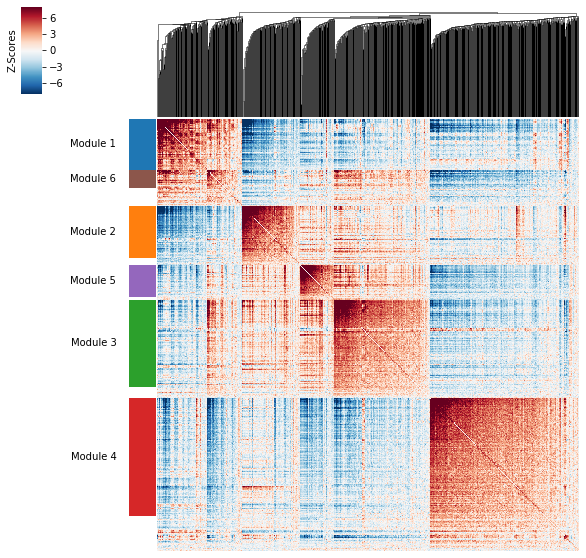

In [6]:
hs.plot_local_correlations()

To explore individual genes, we can look at the genes with the top *autocorrelation* <br>
in a given module as these are likely the most informative.

In [7]:
# Show the top genes for a module

module = 1

results = hs.results.join(hs.modules)
results = results.loc[results.Module == module]
results.sort_values('Z', ascending=False).head(10)

G  EG         stdG           Z         C  Pval  FDR  \
Gene                                                                       
Pcp2     454045.514481   0  4349.885976  104.381015  0.046222   0.0  0.0   
Car8     384470.481798   0  4349.885976   88.386336  0.039361   0.0  0.0   
Itpr1    309992.054843   0  4349.885976   71.264409  0.031606   0.0  0.0   
Pcp4     287016.421190   0  4349.885976   65.982516  0.029496   0.0  0.0   
Pvalb    277574.727119   0  4349.885976   63.811955  0.028504   0.0  0.0   
mt-Cytb  251459.913992   0  4349.885976   57.808392  0.025916   0.0  0.0   
Gpm6b    229566.984067   0  4349.885976   52.775403  0.023639   0.0  0.0   
mt-Nd4   226437.069373   0  4349.885976   52.055863  0.023182   0.0  0.0   
Calb1    198838.797756   0  4349.885976   45.711267  0.020217   0.0  0.0   
Aldoc    187057.748608   0  4349.885976   43.002909  0.019332   0.0  0.0   

         Module  
Gene             
Pcp2        1.0  
Car8        1.0  
Itpr1       1.0  
Pcp4        1.0  
Pvalb       1.0  
mt-Cytb     1.0  
Gpm6b       1.0  
mt-Nd4      1.0  
Calb1       1.0  
Aldoc       1.0

To get an idea of what spatial pattern the module is referencing, we can plot the top <br>
module genes' expression onto the spatial positions

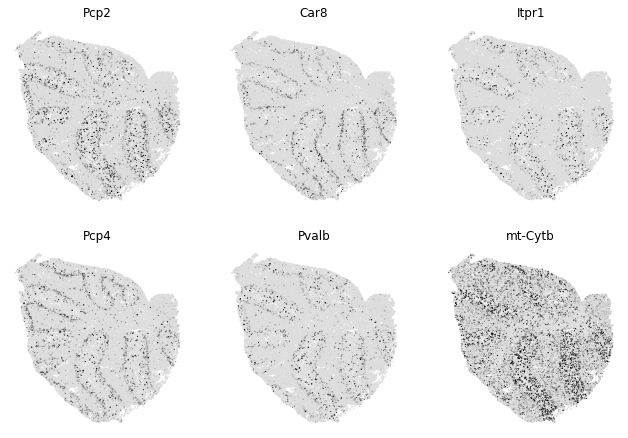

In [9]:
# Plot the module scores on top of positions

module = 1

results = hs.results.join(hs.modules)
results = results.loc[results.Module == module]
genes = results.sort_values('Z', ascending=False).head(6).index

fig, axs = plt.subplots(2, 3, figsize=(11, 7.5))

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'grays', ['#DDDDDD', '#000000'])

for ax, gene in zip(axs.ravel(), genes):
    
    expression = np.log2(hs.counts.loc[gene]/hs.umi_counts*45 + 1) # log-counts per 45 (median UMI/barcode)
    
    vmin = 0
    vmax = np.percentile(expression, 95)
    vmax = 2
    
    plt.sca(ax)
    plt.scatter(x=hs.latent.iloc[:, 0],
                y=hs.latent.iloc[:, 1],
                s=2,
                c=expression,
                vmin=vmin,
                vmax=vmax,
                edgecolors='none',
                cmap=cmap
               )
    
    for sp in ax.spines.values():
        sp.set_visible(False)
        
    plt.xticks([])
    plt.yticks([])
    plt.title(gene)

## Summary Module Scores

To aid in the recognition of the general behavior of a module, Hotspot can compute <br>
aggregate module scores.

In [10]:
module_scores = hs.calculate_module_scores()

module_scores.head()

  0%|          | 0/6 [00:00<?, ?it/s]

Computing scores for 6 modules...


100%|██████████| 6/6 [01:30<00:00, 12.98s/it]


1         2         3         4         5         6
barcodes                                                                  
CGTACAATTTTTTT  0.822729 -0.443706 -0.094899 -0.414559 -0.198448  0.180391
TTCGTTATTTTTTT  1.232227 -0.421417 -0.254999 -0.472261 -0.213982  0.299108
CAAACCAACCCCCC  0.607751 -0.312146 -0.166309  0.234819 -0.328414  0.367822
TCTTTTCACCCCCC  1.286320 -0.491108 -0.053740 -0.736092 -0.096152  0.377854
GGATTGAACCCCCC  0.133101 -0.544696 -0.157040 -0.326436 -0.133297  0.334153

Here we can visualize these module scores by plotting them over the barcode positions:

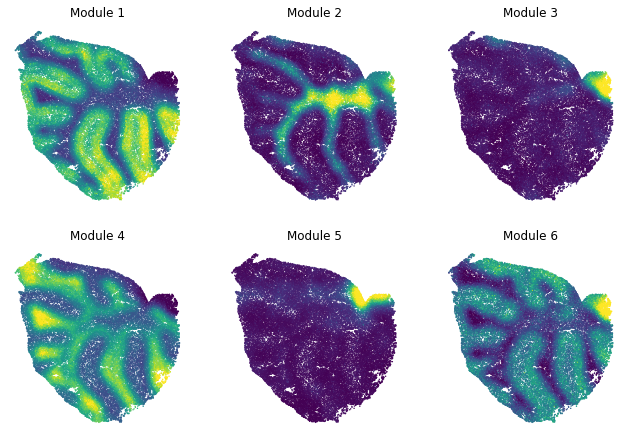

In [11]:
# Plot the module scores on top of positions

fig, axs = plt.subplots(2, 3, figsize=(11, 7.5))

for ax, module in zip(axs.ravel(), range(1, hs.modules.max()+1)):
    scores = hs.module_scores[module]
    
    vmin = np.percentile(scores, 1)
    vmax = np.percentile(scores, 99)
    
    plt.sca(ax)
    plt.scatter(x=hs.latent.iloc[:, 0],
                y=hs.latent.iloc[:, 1],
                s=2,
                c=scores,
                vmin=vmin,
                vmax=vmax,
                edgecolors='none'
               )
    
    for sp in ax.spines.values():
        sp.set_visible(False)
        
    plt.xticks([])
    plt.yticks([])
    plt.title('Module {}'.format(module))